Variational Autoencoder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipython-input-2641787785.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cpu


CIFAR10 dataset. In CIFAR10, each image has 3 color channels and is 32x32 pixels large. As autoencoders do not have the constrain of modeling images probabilistic, we can work on more complex image data (i.e. 3 color channels instead of black-and-white) much easier than for VAEs.


In [3]:
# Transformations applied on each image => only make them a tensor
DATASET_PATH = "/content/drive/MyDrive/Cifar-10/cifar10"
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class VAE(nn.Module):
    def __init__(self, label, image_size, channel_num, kernel_num, z_size):
        super().__init__()
        self.label = label
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        # Calculate feature size based on conv layers
        # Each conv layer with stride=2 halves the spatial dimension
        self.feature_size = image_size // 8
        self.feature_volume = kernel_num * (self.feature_size ** 2)

        # Encoder
        self.encoder = nn.Sequential(
            self._conv(channel_num, kernel_num // 4),
            self._conv(kernel_num // 4, kernel_num // 2),
            self._conv(kernel_num // 2, kernel_num),
        )

        # Latent space layers
        self.q_mean = nn.Linear(self.feature_volume, z_size)
        self.q_logvar = nn.Linear(self.feature_volume, z_size)

        # Decoder projection
        self.project = nn.Linear(z_size, self.feature_volume)

        # Decoder
        # self.decoder = nn.Sequential(
        #     self._deconv(kernel_num, kernel_num // 2),
        #     self._deconv(kernel_num // 2, kernel_num // 4),
        #     self._deconv(kernel_num // 4, channel_num),
        #     nn.Sigmoid()
        # )

        self.deconv1 = self._deconv(kernel_num, kernel_num // 2)
        self.deconv2 = self._deconv(kernel_num // 2, kernel_num // 4)
        self.deconv3 = self._deconv(kernel_num // 4, channel_num)
        self.final_activation = nn.Sigmoid()

        # Add projection layers for skip connections
        self.skip_proj1 = nn.Linear(z_size, (kernel_num // 2) * (self.feature_size * 2) ** 2)
        self.skip_proj2 = nn.Linear(z_size, (kernel_num // 4) * (self.feature_size * 4) ** 2)

    def encode(self, x):
        """Encode input to latent parameters"""
        encoded = self.encoder(x)
        encoded_flat = encoded.view(encoded.size(0), -1)
        mean = self.q_mean(encoded_flat)
        logvar = self.q_logvar(encoded_flat)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        """Decode latent variable to image with skip connections"""
        # Main path
        projected = self.project(z)
        x = projected.view(-1, self.kernel_num, self.feature_size, self.feature_size)

        # Layer 1 with skip
        x = self.deconv1(x)
        skip1 = self.skip_proj1(z).view(-1, self.kernel_num // 2, self.feature_size * 2, self.feature_size * 2)
        x = x + skip1

        # Layer 2 with skip
        x = self.deconv2(x)
        skip2 = self.skip_proj2(z).view(-1, self.kernel_num // 4, self.feature_size * 4, self.feature_size * 4)
        x = x + skip2

        # Final layer
        x = self.deconv3(x)
        return self.final_activation(x)

    # def decode(self, z):
    #     """Decode latent variable to image"""
    #     projected = self.project(z)
    #     projected = projected.view(
    #         -1, self.kernel_num, self.feature_size, self.feature_size
    #     )
    #     return self.decoder(projected)

    def forward(self, x):
        """Forward pass through VAE"""
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_reconstructed = self.decode(z)
        return (mean, logvar), x_reconstructed

    def sample(self, num_samples, device=None):
        """Generate samples from the model"""
        if device is None:
            device = next(self.parameters()).device

        with torch.no_grad():
            z = torch.randn(num_samples, self.z_size, device=device)
            samples = self.decode(z)
        return samples

    def reconstruct(self, x):
        """Reconstruct input images"""
        with torch.no_grad():
            (mean, logvar), x_recon = self.forward(x)
        return x_recon

    def get_latent_representation(self, x):
        """Get latent representation of input"""
        with torch.no_grad():
            mean, logvar = self.encode(x)
            z = self.reparameterize(mean, logvar)
        return z, mean, logvar

    def interpolate(self, x1, x2, num_steps=10):
        """Interpolate between two images in latent space"""
        with torch.no_grad():
            z1, _, _ = self.get_latent_representation(x1)
            z2, _, _ = self.get_latent_representation(x2)

            # Linear interpolation in latent space
            alphas = torch.linspace(0, 1, num_steps, device=z1.device)
            interpolations = []

            for alpha in alphas:
                z_interp = (1 - alpha) * z1 + alpha * z2
                x_interp = self.decode(z_interp)
                interpolations.append(x_interp)

            return torch.cat(interpolations, dim=0)

    def reconstruction_loss(self, x_reconstructed, x, reduction='mean'):
        """Compute reconstruction loss"""
        if reduction == 'mean':
            return F.mse_loss(x_reconstructed, x, reduction='mean')
        else:
            return F.mse_loss(x_reconstructed, x, reduction='sum') / x.size(0)

    def kl_divergence_loss(self, mean, logvar, reduction='mean'):
        """Compute KL divergence loss"""
        kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1)
        if reduction == 'mean':
            return torch.mean(kl_div)
        else:
            return torch.sum(kl_div) / mean.size(0)

    @property
    def name(self):
        return (
            'VAE'
            '-{kernel_num}k'
            '-{label}'
            '-{channel_num}x{image_size}x{image_size}'
            '-z{z_size}'
        ).format(
            label=self.label,
            kernel_num=self.kernel_num,
            image_size=self.image_size,
            channel_num=self.channel_num,
            z_size=self.z_size,
        )

    def _conv(self, in_channels, out_channels):
        """Convolutional block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def _deconv(self, in_channels, out_channels):
        """Transposed convolutional block"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )



In [51]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np


def get_data_loader(dataset, batch_size, shuffle=True, num_workers=0):
    """Create data loader with Windows-compatible settings"""
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,  # Set to 0 for Windows compatibility
        pin_memory=torch.cuda.is_available()
    )


def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir, beta):
    """Save model checkpoint"""
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint_path = os.path.join(checkpoint_dir, f"{model.name}_epoch_{epoch}_beta_{beta * 10}.pth")
    torch.save({
        'epoch': epoch,
        'model': model,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'model_config': {
            'label': model.label,
            'image_size': model.image_size,
            'channel_num': model.channel_num,
            'kernel_num': model.kernel_num,
            'z_size': model.z_size
        }
    }, checkpoint_path)
    print(f'=> Saved checkpoint: {checkpoint_path}')
    return checkpoint_path



def load_checkpoint(checkpoint_path):

    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    model = checkpoint['model']  # Load complete model
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss



def save_samples(model, epoch, sample_size, sample_dir, device, beta):
    """Save generated samples"""
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    model.eval()
    with torch.no_grad():
        samples = model.sample(sample_size, device)
        sample_path = os.path.join(sample_dir, f'samples_epoch_{epoch}_beta_{beta}.png')
        vutils.save_image(samples, sample_path, nrow=int(np.sqrt(sample_size)), normalize=True)
        print(f'=> Saved samples: {sample_path}')
    model.train()


def save_reconstructions(model, data_loader, epoch, sample_dir, device, num_samples=8):
    """Save reconstruction comparisons"""
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    model.eval()
    with torch.no_grad():
        # Get a batch of real images
        real_batch = next(iter(data_loader))[0][:num_samples].to(device)
        reconstructed = model.reconstruct(real_batch)

        # Create comparison grid
        comparison = torch.cat([real_batch, reconstructed], dim=0)
        recon_path = os.path.join(sample_dir, f'reconstructions_epoch_{epoch}.png')
        vutils.save_image(comparison, recon_path, nrow=num_samples, normalize=True)
        print(f'=> Saved reconstructions: {recon_path}')
    model.train()


class TrainingLogger:
    """Simple training logger for plotting losses"""
    def __init__(self):
        self.losses = {
            'total': [],
            'reconstruction': [],
            'kl_divergence': []
        }
        self.epochs = []

    def log(self, epoch, total_loss, recon_loss, kl_loss):
        self.epochs.append(epoch)
        self.losses['total'].append(total_loss)
        self.losses['reconstruction'].append(recon_loss)
        self.losses['kl_divergence'].append(kl_loss)

    def plot(self, save_path=None):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(self.epochs, self.losses['total'])
        plt.title('Total Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 3, 2)
        plt.plot(self.epochs, self.losses['reconstruction'])
        plt.title('Reconstruction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 3, 3)
        plt.plot(self.epochs, self.losses['kl_divergence'])
        plt.title('KL Divergence Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
            print(f'=> Saved loss plot: {save_path}')
        plt.show()


def train_model(model, dataset, epochs=10, batch_size=32, sample_size=64,
                lr=1e-3, weight_decay=1e-5, beta=1.0,
                loss_log_interval=100, image_log_interval=500,
                checkpoint_dir='./checkpoints', sample_dir='./samples',
                resume=False, device='cuda'):
    """
    Train the VAE model

    Args:
        model: VAE model
        dataset: Training dataset
        epochs: Number of epochs
        batch_size: Batch size
        sample_size: Number of samples to generate
        lr: Learning rate
        weight_decay: Weight decay
        beta: Beta parameter for beta-VAE (1.0 for standard VAE)
        loss_log_interval: Interval for logging losses
        image_log_interval: Interval for saving images
        checkpoint_dir: Directory to save checkpoints
        sample_dir: Directory to save samples
        resume: Resume from checkpoint
        device: Device to train on
    """

    # Setup
    model = model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    data_loader = get_data_loader(dataset, batch_size)
    logger = TrainingLogger()

    # Resume from checkpoint if specified
    start_epoch = 1
    if resume:
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith(model.name) and f.endswith('.pth')]
        if checkpoint_files:
            latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_epoch_')[1].split('.pth')[0]))
            checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
            start_epoch = load_checkpoint(model, optimizer, checkpoint_path) + 1

    print(f"Training VAE on {device}")
    print(f"Dataset: {len(dataset)} samples")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {lr}")
    print(f"Beta (KL weight): {beta}")
    print("-" * 50)

    for epoch in range(start_epoch, epochs + 1):
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        num_batches = 0

        progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}/{epochs}')

        for batch_idx, (data, _) in enumerate(progress_bar):
            data = data.to(device)

            # Forward pass
            optimizer.zero_grad()
            (mean, logvar), reconstructed = model(data)

            # Compute losses
            recon_loss = model.reconstruction_loss(reconstructed, data)
            kl_loss = model.kl_divergence_loss(mean, logvar)
            # kl_weight = min(1.0, batch_idx / (len(data_loader) * 10)) * beta
            total_loss = recon_loss + beta * kl_loss

            # Backward pass
            total_loss.backward()
            optimizer.step()

            # Update running averages
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'Total': f'{total_loss.item():.4f}',
                'Recon': f'{recon_loss.item():.4f}',
                'KL': f'{kl_loss.item():.4f}'
            })

            # Log losses periodically
            if batch_idx % loss_log_interval == 0:
                iteration = (epoch - 1) * len(data_loader) + batch_idx
                print(f'Epoch: {epoch}, Batch: {batch_idx}, '
                      f'Total Loss: {total_loss.item():.4f}, '
                      f'Recon Loss: {recon_loss.item():.4f}, '
                      f'KL Loss: {kl_loss.item():.4f}')

        # End of epoch logging
        avg_total_loss = epoch_total_loss / num_batches
        avg_recon_loss = epoch_recon_loss / num_batches
        avg_kl_loss = epoch_kl_loss / num_batches

        logger.log(epoch, avg_total_loss, avg_recon_loss, avg_kl_loss)

        print(f'\nEpoch {epoch} Summary:')
        print(f'  Average Total Loss: {avg_total_loss:.4f}')
        print(f'  Average Recon Loss: {avg_recon_loss:.4f}')
        print(f'  Average KL Loss: {avg_kl_loss:.4f}')

        # Save samples and reconstructions
        if epoch % image_log_interval == 0 or epoch == epochs:
            save_samples(model, epoch, sample_size, sample_dir, device, beta)
            save_reconstructions(model, data_loader, epoch, sample_dir, device)

        # Save checkpoint
        if epoch % image_log_interval == 0 or epoch == epochs:
            save_checkpoint(model, optimizer, epoch, avg_total_loss, checkpoint_dir, beta)

        print("-" * 50)

    # Plot final loss curves
    plot_path = os.path.join(sample_dir, 'training_losses.png')
    logger.plot(plot_path)

    print("Training completed!")
    return logger

In [52]:

def save_epoch_samples(model, epoch, sample_size, sample_dir, device, grid_size=8, beta=0.3):
    """Save generated samples for specific epoch (for slider creation later)"""
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    model.eval()
    try:
        with torch.no_grad():
            samples = model.sample(sample_size, device)
            sample_path = os.path.join(sample_dir, f'epoch_{epoch:03d}_samples_beta_{beta * 10}.png')
            vutils.save_image(samples, sample_path, nrow=grid_size, normalize=True)
            print(f'=> Saved epoch {epoch} samples: {sample_path}')
    except Exception as e:
        print(f"Error loading checkpoint {e}")

    model.train()



def create_generation_slider(sample_dir, epochs_list, figsize=(15, 8)):
    """Create interactive slider showing generation progress across epochs"""
    import glob
    from IPython.display import display
    import ipywidgets as widgets
    from PIL import Image

    # Find all sample images
    sample_files = []
    for epoch in epochs_list:
        pattern = os.path.join(sample_dir, f'epoch_{epoch:03d}_samples_beta_0.3.png')
        if os.path.exists(pattern):
            sample_files.append((epoch, pattern))

    if not sample_files:
        print("No sample images found!")
        return

    sample_files.sort(key=lambda x: x[0])  # Sort by epoch

    def show_samples(epoch_idx):
        epoch, filepath = sample_files[epoch_idx]

        plt.figure(figsize=figsize)
        img = Image.open(filepath)
        plt.imshow(img)
        plt.title(f'Generated Samples - Epoch {epoch}', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # Create slider
    epoch_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(sample_files)-1,
        step=1,
        description='Epoch:',
        continuous_update=False
    )

    # Display epoch numbers on slider
    epoch_labels = [f"Epoch {epoch}" for epoch, _ in sample_files]
    print(f"Available epochs: {[epoch for epoch, _ in sample_files]}")

    widgets.interact(show_samples, epoch_idx=epoch_slider)

In [59]:
from torchsummary import summary
model = VAE(
    label='CIFAR10',
    image_size=32,  # CIFAR-10 is 32x32
    channel_num=3,  # CIFAR-10 has 3 color channels
    kernel_num=64,
    z_size=15
)

summary(model, input_size=(3, 32, 32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           8,224
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          32,832
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Linear-10                   [-1, 15]          15,375
           Linear-11                   [-1, 15]          15,375
           Linear-12                 [-1, 1024]          16,384
  ConvTranspose2d-13             [-1, 32, 8, 8]          32,800
      BatchNorm2d-14             [-1, 3

Using device: cpu
Training VAE on cpu
Dataset: 45000 samples
Batch size: 128
Epochs: 10
Learning rate: 0.01
Beta (KL weight): 0.9
--------------------------------------------------


Epoch 1/10:   0%|          | 1/352 [00:00<00:49,  7.10it/s, Total=2.5258, Recon=0.6732, KL=2.0584]

Epoch: 1, Batch: 0, Total Loss: 2.5258, Recon Loss: 0.6732, KL Loss: 2.0584


Epoch 1/10:  29%|██▉       | 102/352 [00:15<00:34,  7.24it/s, Total=0.6301, Recon=0.5711, KL=0.0655]

Epoch: 1, Batch: 100, Total Loss: 0.5846, Recon Loss: 0.5353, KL Loss: 0.0547


Epoch 1/10:  57%|█████▋    | 202/352 [00:30<00:19,  7.54it/s, Total=0.6124, Recon=0.5837, KL=0.0319]

Epoch: 1, Batch: 200, Total Loss: 0.5981, Recon Loss: 0.5663, KL Loss: 0.0353


Epoch 1/10:  86%|████████▌ | 302/352 [00:45<00:06,  7.52it/s, Total=0.5381, Recon=0.5215, KL=0.0185]

Epoch: 1, Batch: 300, Total Loss: 0.5372, Recon Loss: 0.5214, KL Loss: 0.0175


Epoch 1/10: 100%|██████████| 352/352 [00:53<00:00,  6.54it/s, Total=0.5437, Recon=0.5261, KL=0.0195]



Epoch 1 Summary:
  Average Total Loss: 2.2559
  Average Recon Loss: 0.5624
  Average KL Loss: 1.8817
--------------------------------------------------


Epoch 2/10:   0%|          | 1/352 [00:00<00:46,  7.48it/s, Total=0.5806, Recon=0.5686, KL=0.0134]

Epoch: 2, Batch: 0, Total Loss: 0.5806, Recon Loss: 0.5686, KL Loss: 0.0134


Epoch 2/10:  29%|██▉       | 102/352 [00:15<00:34,  7.17it/s, Total=0.5556, Recon=0.5478, KL=0.0087]

Epoch: 2, Batch: 100, Total Loss: 0.5775, Recon Loss: 0.5688, KL Loss: 0.0097


Epoch 2/10:  57%|█████▋    | 202/352 [00:30<00:19,  7.52it/s, Total=0.6039, Recon=0.5971, KL=0.0076]

Epoch: 2, Batch: 200, Total Loss: 0.5342, Recon Loss: 0.5275, KL Loss: 0.0074


Epoch 2/10:  86%|████████▌ | 302/352 [00:45<00:06,  7.21it/s, Total=0.5498, Recon=0.5435, KL=0.0071]

Epoch: 2, Batch: 300, Total Loss: 0.5684, Recon Loss: 0.5619, KL Loss: 0.0072


Epoch 2/10: 100%|██████████| 352/352 [00:52<00:00,  6.70it/s, Total=0.5880, Recon=0.5823, KL=0.0064]



Epoch 2 Summary:
  Average Total Loss: 0.5670
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0090
=> Saved samples: /content/drive/MyDrive/VAE/samples/samples_epoch_2_beta_0.9.png
=> Saved reconstructions: /content/drive/MyDrive/VAE/samples/reconstructions_epoch_2.png
=> Saved checkpoint: /content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_2_beta_9.0.pth
--------------------------------------------------


Epoch 3/10:   0%|          | 1/352 [00:00<01:08,  5.16it/s, Total=0.5399, Recon=0.5350, KL=0.0055]

Epoch: 3, Batch: 0, Total Loss: 0.5399, Recon Loss: 0.5350, KL Loss: 0.0055


Epoch 3/10:  29%|██▉       | 102/352 [00:15<00:48,  5.17it/s, Total=0.5510, Recon=0.5451, KL=0.0066]

Epoch: 3, Batch: 100, Total Loss: 0.6447, Recon Loss: 0.6400, KL Loss: 0.0051


Epoch 3/10:  57%|█████▋    | 202/352 [00:31<00:26,  5.69it/s, Total=0.6188, Recon=0.6156, KL=0.0036]

Epoch: 3, Batch: 200, Total Loss: 0.5859, Recon Loss: 0.5812, KL Loss: 0.0051


Epoch 3/10:  86%|████████▌ | 302/352 [00:46<00:06,  7.27it/s, Total=0.5824, Recon=0.5789, KL=0.0039]

Epoch: 3, Batch: 300, Total Loss: 0.5663, Recon Loss: 0.5627, KL Loss: 0.0040


Epoch 3/10: 100%|██████████| 352/352 [00:53<00:00,  6.59it/s, Total=0.5926, Recon=0.5882, KL=0.0048]



Epoch 3 Summary:
  Average Total Loss: 0.5632
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0047
--------------------------------------------------


Epoch 4/10:   0%|          | 1/352 [00:00<00:46,  7.62it/s, Total=0.5423, Recon=0.5391, KL=0.0035]

Epoch: 4, Batch: 0, Total Loss: 0.5423, Recon Loss: 0.5391, KL Loss: 0.0035


Epoch 4/10:  29%|██▉       | 102/352 [00:14<00:33,  7.47it/s, Total=0.5966, Recon=0.5928, KL=0.0043]

Epoch: 4, Batch: 100, Total Loss: 0.5395, Recon Loss: 0.5367, KL Loss: 0.0031


Epoch 4/10:  57%|█████▋    | 202/352 [00:29<00:19,  7.61it/s, Total=0.5552, Recon=0.5529, KL=0.0025]

Epoch: 4, Batch: 200, Total Loss: 0.5687, Recon Loss: 0.5667, KL Loss: 0.0022


Epoch 4/10:  86%|████████▌ | 301/352 [00:44<00:08,  6.12it/s, Total=0.5652, Recon=0.5619, KL=0.0037]

Epoch: 4, Batch: 300, Total Loss: 0.5652, Recon Loss: 0.5619, KL Loss: 0.0037


Epoch 4/10: 100%|██████████| 352/352 [00:52<00:00,  6.70it/s, Total=0.5460, Recon=0.5442, KL=0.0019]



Epoch 4 Summary:
  Average Total Loss: 0.5615
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0030
=> Saved samples: /content/drive/MyDrive/VAE/samples/samples_epoch_4_beta_0.9.png
=> Saved reconstructions: /content/drive/MyDrive/VAE/samples/reconstructions_epoch_4.png
=> Saved checkpoint: /content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_4_beta_9.0.pth
--------------------------------------------------


Epoch 5/10:   1%|          | 2/352 [00:00<00:47,  7.31it/s, Total=0.5616, Recon=0.5599, KL=0.0019]

Epoch: 5, Batch: 0, Total Loss: 0.5675, Recon Loss: 0.5659, KL Loss: 0.0018


Epoch 5/10:  29%|██▉       | 102/352 [00:15<00:33,  7.52it/s, Total=0.5596, Recon=0.5576, KL=0.0022]

Epoch: 5, Batch: 100, Total Loss: 0.5265, Recon Loss: 0.5242, KL Loss: 0.0026


Epoch 5/10:  57%|█████▋    | 202/352 [00:29<00:20,  7.36it/s, Total=0.5577, Recon=0.5560, KL=0.0019]

Epoch: 5, Batch: 200, Total Loss: 0.5733, Recon Loss: 0.5717, KL Loss: 0.0018


Epoch 5/10:  86%|████████▌ | 302/352 [00:44<00:07,  6.85it/s, Total=0.5676, Recon=0.5656, KL=0.0022]

Epoch: 5, Batch: 300, Total Loss: 0.5509, Recon Loss: 0.5487, KL Loss: 0.0025


Epoch 5/10: 100%|██████████| 352/352 [00:53<00:00,  6.60it/s, Total=0.5433, Recon=0.5421, KL=0.0013]



Epoch 5 Summary:
  Average Total Loss: 0.5608
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0022
--------------------------------------------------


Epoch 6/10:   0%|          | 1/352 [00:00<00:57,  6.13it/s, Total=0.5319, Recon=0.5306, KL=0.0014]

Epoch: 6, Batch: 0, Total Loss: 0.5319, Recon Loss: 0.5306, KL Loss: 0.0014


Epoch 6/10:  29%|██▊       | 101/352 [00:18<00:50,  4.96it/s, Total=0.5075, Recon=0.5047, KL=0.0031]

Epoch: 6, Batch: 100, Total Loss: 0.5075, Recon Loss: 0.5047, KL Loss: 0.0031


Epoch 6/10:  57%|█████▋    | 201/352 [00:48<00:52,  2.86it/s, Total=0.5664, Recon=0.5651, KL=0.0014]

Epoch: 6, Batch: 200, Total Loss: 0.5664, Recon Loss: 0.5651, KL Loss: 0.0014


Epoch 6/10:  86%|████████▌ | 301/352 [01:33<00:29,  1.73it/s, Total=0.5677, Recon=0.5656, KL=0.0023]

Epoch: 6, Batch: 300, Total Loss: 0.5677, Recon Loss: 0.5656, KL Loss: 0.0023


Epoch 6/10: 100%|██████████| 352/352 [01:57<00:00,  3.00it/s, Total=0.5741, Recon=0.5724, KL=0.0019]



Epoch 6 Summary:
  Average Total Loss: 0.5608
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0022
=> Saved samples: /content/drive/MyDrive/VAE/samples/samples_epoch_6_beta_0.9.png
=> Saved reconstructions: /content/drive/MyDrive/VAE/samples/reconstructions_epoch_6.png
=> Saved checkpoint: /content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_6_beta_9.0.pth
--------------------------------------------------


Epoch 7/10:   0%|          | 1/352 [00:00<03:41,  1.59it/s, Total=0.5546, Recon=0.5531, KL=0.0017]

Epoch: 7, Batch: 0, Total Loss: 0.5546, Recon Loss: 0.5531, KL Loss: 0.0017


Epoch 7/10:  29%|██▊       | 101/352 [00:50<01:57,  2.14it/s, Total=0.6024, Recon=0.6010, KL=0.0016]

Epoch: 7, Batch: 100, Total Loss: 0.6024, Recon Loss: 0.6010, KL Loss: 0.0016


Epoch 7/10:  57%|█████▋    | 201/352 [01:39<01:12,  2.09it/s, Total=0.5853, Recon=0.5838, KL=0.0017]

Epoch: 7, Batch: 200, Total Loss: 0.5853, Recon Loss: 0.5838, KL Loss: 0.0017


Epoch 7/10:  86%|████████▌ | 301/352 [02:26<00:22,  2.31it/s, Total=0.5361, Recon=0.5350, KL=0.0012]

Epoch: 7, Batch: 300, Total Loss: 0.5361, Recon Loss: 0.5350, KL Loss: 0.0012


Epoch 7/10: 100%|██████████| 352/352 [02:49<00:00,  2.07it/s, Total=0.5499, Recon=0.5464, KL=0.0039]



Epoch 7 Summary:
  Average Total Loss: 0.5613
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0027
--------------------------------------------------


Epoch 8/10:   0%|          | 1/352 [00:00<02:28,  2.36it/s, Total=0.5634, Recon=0.5623, KL=0.0012]

Epoch: 8, Batch: 0, Total Loss: 0.5634, Recon Loss: 0.5623, KL Loss: 0.0012


Epoch 8/10:  29%|██▊       | 101/352 [00:43<01:44,  2.39it/s, Total=0.5768, Recon=0.5739, KL=0.0033]

Epoch: 8, Batch: 100, Total Loss: 0.5768, Recon Loss: 0.5739, KL Loss: 0.0033


Epoch 8/10:  57%|█████▋    | 201/352 [01:31<01:14,  2.02it/s, Total=0.5586, Recon=0.5573, KL=0.0014]

Epoch: 8, Batch: 200, Total Loss: 0.5586, Recon Loss: 0.5573, KL Loss: 0.0014


Epoch 8/10:  86%|████████▌ | 301/352 [02:26<00:30,  1.65it/s, Total=0.5807, Recon=0.5800, KL=0.0009]

Epoch: 8, Batch: 300, Total Loss: 0.5807, Recon Loss: 0.5800, KL Loss: 0.0009


Epoch 8/10: 100%|██████████| 352/352 [02:57<00:00,  1.98it/s, Total=0.5847, Recon=0.5839, KL=0.0008]



Epoch 8 Summary:
  Average Total Loss: 0.5623
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0038
=> Saved samples: /content/drive/MyDrive/VAE/samples/samples_epoch_8_beta_0.9.png
=> Saved reconstructions: /content/drive/MyDrive/VAE/samples/reconstructions_epoch_8.png
=> Saved checkpoint: /content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_8_beta_9.0.pth
--------------------------------------------------


Epoch 9/10:   0%|          | 1/352 [00:00<03:30,  1.67it/s, Total=0.5514, Recon=0.5503, KL=0.0012]

Epoch: 9, Batch: 0, Total Loss: 0.5514, Recon Loss: 0.5503, KL Loss: 0.0012


Epoch 9/10:  29%|██▊       | 101/352 [01:04<02:31,  1.65it/s, Total=0.5877, Recon=0.5869, KL=0.0009]

Epoch: 9, Batch: 100, Total Loss: 0.5877, Recon Loss: 0.5869, KL Loss: 0.0009


Epoch 9/10:  57%|█████▋    | 201/352 [02:09<01:32,  1.64it/s, Total=0.5314, Recon=0.5304, KL=0.0011]

Epoch: 9, Batch: 200, Total Loss: 0.5314, Recon Loss: 0.5304, KL Loss: 0.0011


Epoch 9/10:  86%|████████▌ | 301/352 [03:06<00:26,  1.90it/s, Total=0.5742, Recon=0.5726, KL=0.0018]

Epoch: 9, Batch: 300, Total Loss: 0.5742, Recon Loss: 0.5726, KL Loss: 0.0018


Epoch 9/10: 100%|██████████| 352/352 [03:33<00:00,  1.65it/s, Total=0.5982, Recon=0.5955, KL=0.0029]



Epoch 9 Summary:
  Average Total Loss: 0.5600
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0011
--------------------------------------------------


Epoch 10/10:   0%|          | 1/352 [00:00<02:52,  2.03it/s, Total=0.5616, Recon=0.5562, KL=0.0060]

Epoch: 10, Batch: 0, Total Loss: 0.5616, Recon Loss: 0.5562, KL Loss: 0.0060


Epoch 10/10:  29%|██▊       | 101/352 [00:49<02:20,  1.79it/s, Total=0.5699, Recon=0.5686, KL=0.0015]

Epoch: 10, Batch: 100, Total Loss: 0.5699, Recon Loss: 0.5686, KL Loss: 0.0015


Epoch 10/10:  57%|█████▋    | 201/352 [01:34<01:05,  2.30it/s, Total=0.5679, Recon=0.5659, KL=0.0022]

Epoch: 10, Batch: 200, Total Loss: 0.5679, Recon Loss: 0.5659, KL Loss: 0.0022


Epoch 10/10:  86%|████████▌ | 301/352 [02:24<00:32,  1.58it/s, Total=0.5802, Recon=0.5790, KL=0.0013]

Epoch: 10, Batch: 300, Total Loss: 0.5802, Recon Loss: 0.5790, KL Loss: 0.0013


Epoch 10/10: 100%|██████████| 352/352 [02:52<00:00,  2.04it/s, Total=0.5553, Recon=0.5549, KL=0.0005]



Epoch 10 Summary:
  Average Total Loss: 0.5615
  Average Recon Loss: 0.5589
  Average KL Loss: 0.0029
=> Saved samples: /content/drive/MyDrive/VAE/samples/samples_epoch_10_beta_0.9.png
=> Saved reconstructions: /content/drive/MyDrive/VAE/samples/reconstructions_epoch_10.png
=> Saved checkpoint: /content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_10_beta_9.0.pth
--------------------------------------------------
=> Saved loss plot: /content/drive/MyDrive/VAE/samples/training_losses.png


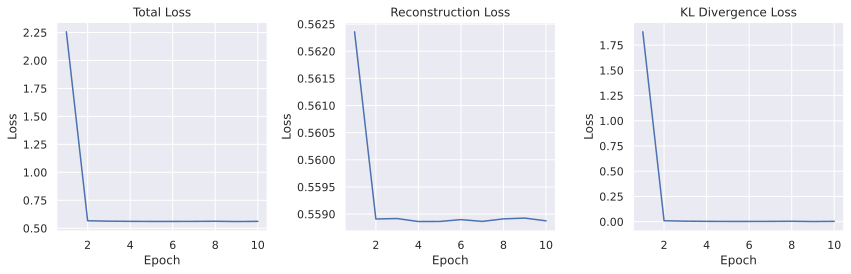

Training completed!


In [57]:
import torch
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create VAE model for CIFAR-10
model = VAE(
    label='CIFAR10',
    image_size=32,  # CIFAR-10 is 32x32
    channel_num=3,  # CIFAR-10 has 3 color channels
    kernel_num=64,
    z_size=15
)

# Training parameters
epochs = 10
batch_size = 128
lr = 1e-2
beta = 0.9
checkpoint_interval = 2  # Save checkpoint every 2 epochs

# Create directories
checkpoint_dir = '/content/drive/MyDrive/VAE/checkpoints'
sample_dir = '/content/drive/MyDrive/VAE/samples'

# Train the model using your existing train_set
logger = train_model(
    model=model,
    dataset=train_set,  # Using your CIFAR-10 train_set
    epochs=epochs,
    image_log_interval=checkpoint_interval,
    batch_size=batch_size,
    lr=lr,
    beta=beta,
    checkpoint_dir=checkpoint_dir,
    sample_dir=sample_dir,
    device=device
)

# Generate samples for slider (every checkpoint epoch)


In [58]:
print("Generating samples for slider...")
epochs_to_sample = list(range(checkpoint_interval, epochs + 1, checkpoint_interval))

for epoch in epochs_to_sample:
    # Load checkpoint for this epoch
    checkpoint_path = f'{checkpoint_dir}/{model.name}_epoch_{epoch}_beta_{beta}.pth'  # Use correct path
    print(checkpoint_path)
    if os.path.exists(checkpoint_path):

        load_checkpoint(checkpoint_path)
        save_epoch_samples(model, epoch, sample_size=64, sample_dir=sample_dir, device=device, beta=4)

print("Training completed! Run the slider to see generation progress.")

# To create slider after training, run this:
create_generation_slider('/content/drive/MyDrive/VAE/samples', epochs_to_sample)

Generating samples for slider...
/content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_2_beta_0.9.pth
/content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_4_beta_0.9.pth
/content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_6_beta_0.9.pth
/content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_8_beta_0.9.pth
/content/drive/MyDrive/VAE/checkpoints/VAE-64k-CIFAR10-3x32x32-z15_epoch_10_beta_0.9.pth
Training completed! Run the slider to see generation progress.
Available epochs: [2, 4, 6, 8, 10]


interactive(children=(IntSlider(value=0, continuous_update=False, description='Epoch:', max=4), Output()), _do…

In [5]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

### Training the model

During the training, we want to keep track of the learning progress by seeing reconstructions made by our model. For this, we implement a callback object in PyTorch Lightning which will add reconstructions every $N$ epochs to our tensorboard:

We will now write a training function that allows us to train the autoencoder with different latent dimensionality and returns both the test and validation score. We provide pre-trained models and recommend you using those, especially when you work on a computer without GPU. Of course, feel free to train your own models on Snellius.